# **Setup and Load Data**

# Install dependecies and setup
Tensorflow for pipelining, opencv for cleaning dataset, matplotlib for visualization

In [ ]:

%pip install tensorflow tensorflow-gpu opencv-python matplotlib 

Validation

In [ ]:
%pip list

Importing dependecies

In [ ]:
import tensorflow as tf
import os 
#navigate through file structures
from tensorflow import keras
from keras import layers

Limiting gpu vrm usage 

In [ ]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [ ]:
os.chdir('D:\\project')
data_dir = 'trainData'

In [ ]:
os.listdir(data_dir)

Sorting, Pipelining and Loading Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

Building data pipeline

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('trainData')

For accessing the pipeline, data visualization, using batchs

In [ ]:
data_iterator = data.as_numpy_iterator()

In [56]:
batch = data_iterator.next()

In [ ]:
# Images represented as numpy arrays
batch

In [ ]:
len(batch)
#images, labels

In [48]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [57]:

batch[1]

array([4, 2, 0, 4, 4, 2, 3, 0, 3, 0, 0, 2, 0, 1, 0, 0, 1, 5, 5, 0, 2, 0,
       0, 0, 5, 0, 0, 0, 0, 0, 5, 4])

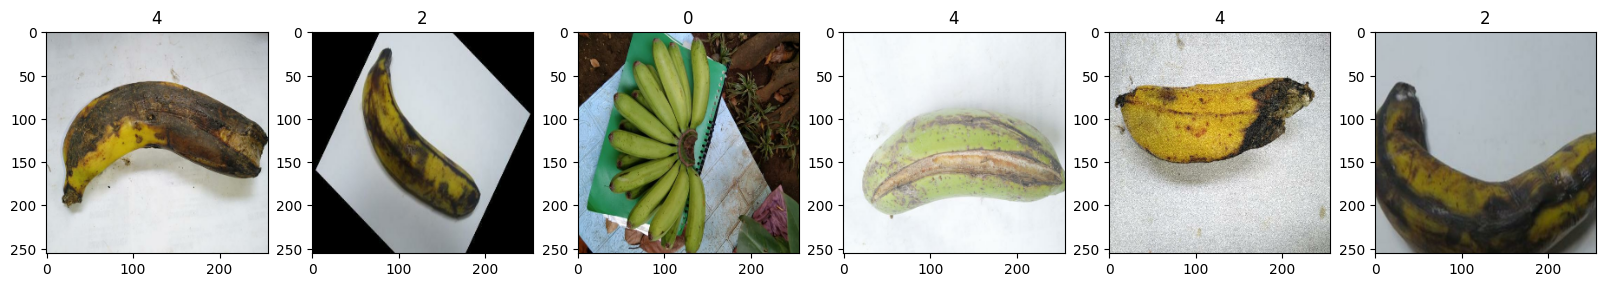

In [58]:
#checking which class is assign to which type of image

fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])